# AML21: 04 Convolutional Neural Network for CIFAR-10
Based on https://github.com/Atcold/pytorch-Deep-Learning


## Data and Libraries

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
import numpy, random


# set the PseudoRandom Generator Seeds for better reproducibility
# see here for more: https://pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(99)
random.seed(99)
numpy.random.seed(99)

# this 'device' will be used for training our model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### **Load the CIFAR10 dataset**
Observe that we set `shuffle=True`, which means that data is randomized

In [8]:
input_size  = 32*32*3   # images are 32x32 pixels with 3 channels
output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=1000, shuffle=True)

classNames= ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified


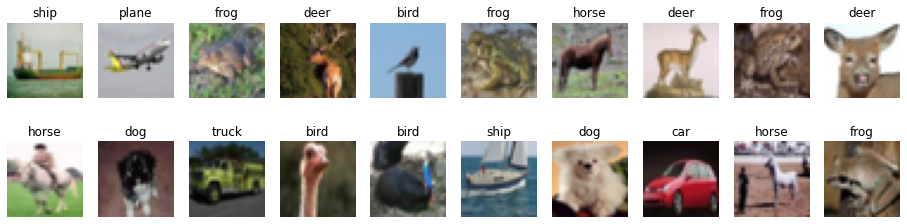

In [9]:
# show some training images
def imshow(img, plot):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()   # convert from tensor
    plot.imshow(numpy.transpose(npimg, (1, 2, 0))) 
    

plt.figure(figsize=(16,4))

# fetch a batch of train images; RANDOM
image_batch, label_batch = next(iter(train_loader))
#imshow(torchvision.utils.make_grid(image_batch))
for i in range(20):
    image = image_batch[i]
    label = classNames[label_batch[i].item()]
    plt.subplot(2, 10, i + 1)
    #image, label = train_loader.dataset.__getitem__(i)
    #plt.imshow(image.squeeze().numpy())
    imshow(image, plt)
    plt.axis('off')
    plt.title(label)
plt.show()

## A 2-hidden layer Fully Connected Neural Network


### Helper functions for training and testing

In [10]:
# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

accuracy_list = []
# we pass a model object to this trainer, and it trains this model for one epoch
def train(epoch, model):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

### A small Convolutional Neural Network

In [11]:
class CNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=50, kernel_size=3, padding=0)
        self.conv2 = nn.Conv2d(in_channels=50, out_channels=50, kernel_size=6, padding=0)
        self.conv3 = nn.Conv2d(in_channels=50, out_channels=50, kernel_size=6, padding=0)
        self.FLATTEN_LEN=50*3*3
        self.fc1 = nn.Linear(self.FLATTEN_LEN, 10)
        #self.fc2 = nn.Linear(200, 10)
        
    def forward(self, x, verbose=False):
        #print("input", x.shape)
        
        x = self.conv1(x)      
        x = F.relu(x)
        #print("after conv1", x.shape)
        
        x = self.conv2(x)       
        x = F.relu(x)
        #print("after conv2", x.shape)
        
        x = F.max_pool2d(x, kernel_size=2)
        #print("after 1st maxpool", x.shape)
        
        x = self.conv3(x)
        x = F.relu(x)
        #print("after conv3", x.shape)
        
        x = F.max_pool2d(x, kernel_size=2)
        #print("after 2nd maxpool", x.shape)
        
        x = x.view(-1, self.FLATTEN_LEN)
        #print("after tensor shape change", x.shape)
        
        x = self.fc1(x)
        #x = F.relu(x)
        #print("after fc1", x.shape)
        
        #x = self.fc2(x)
        ##print("after fc2", x.shape)
        
        x = F.log_softmax(x, dim=1)
        return x

### Sample output of tensor shapes with above print command
```
Training on  cuda:0
Number of parameters: 290890
input torch.Size([64, 3, 32, 32])
after conv1 torch.Size([64, 20, 30, 30])
after conv2 torch.Size([64, 40, 25, 25])
after 1st maxpool torch.Size([64, 40, 12, 12])
after conv3 torch.Size([64, 80, 7, 7])
after 2nd maxpool torch.Size([64, 80, 3, 3])
after tensor shape change torch.Size([64, 720])
after fc1 torch.Size([64, 200])
after fc2 torch.Size([64, 10])
```

In [12]:
print("Training on ", device)
model_cnn = CNN(input_size, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 10):
    train(epoch, model_cnn)
    test(model_cnn)

Training on  cuda:0
Number of parameters: 186010
Train Epoch: 0 [0/50000 (0%)]	Loss: 2.308862
Train Epoch: 0 [6400/50000 (13%)]	Loss: 2.129453
Train Epoch: 0 [12800/50000 (26%)]	Loss: 2.006634
Train Epoch: 0 [19200/50000 (38%)]	Loss: 1.840536
Train Epoch: 0 [25600/50000 (51%)]	Loss: 1.971598
Train Epoch: 0 [32000/50000 (64%)]	Loss: 1.737201
Train Epoch: 0 [38400/50000 (77%)]	Loss: 1.844822
Train Epoch: 0 [44800/50000 (90%)]	Loss: 1.590996

Test set: Average loss: 1.6675, Accuracy: 3981/10000 (40%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.702338
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.463339
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.544069
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.727243
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.441555
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.710955
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.348709
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.377605

Test set: Average loss: 1.5522, Accuracy: 4434/10000 (44%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.600

### Myrtle5 Network

In [13]:
class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), x.size(1))

class CNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNN, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.C = 64
        self.network = nn.Sequential(
                # Layer 0
                nn.Conv2d(3, self.C, kernel_size=3, stride=1,
                          padding=1, bias=True),
                nn.BatchNorm2d(self.C),
                nn.ReLU(),

                # Layer 1
                nn.Conv2d(self.C, self.C*2, kernel_size=3,
                          stride=1, padding=1, bias=True),
                nn.BatchNorm2d(self.C*2),
                nn.ReLU(),
                nn.MaxPool2d(2),

                # Layer 2
                nn.Conv2d(self.C*2, self.C*4, kernel_size=3,
                          stride=1, padding=1, bias=True),
                nn.BatchNorm2d(self.C*4),
                nn.ReLU(),
                nn.MaxPool2d(2),

                # Layer 3
                nn.Conv2d(self.C*4, self.C*8, kernel_size=3,
                          stride=1, padding=1, bias=True),
                nn.BatchNorm2d(self.C*8),
                nn.ReLU(),
                nn.MaxPool2d(2),

                # Layer 4
                nn.MaxPool2d(4),
                Flatten(),
                nn.Linear(self.C*8, output_size, bias=True),
                nn.LogSoftmax(dim=1)
            )
    
    def forward(self, x):
        return self.network(x)

### Train the Network

In [14]:
print("Training on ", device)
model_cnn = CNN(input_size, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 10):
    train(epoch, model_cnn)
    test(model_cnn)

Training on  cuda:0
Number of parameters: 1558026
Train Epoch: 0 [0/50000 (0%)]	Loss: 2.617300
Train Epoch: 0 [6400/50000 (13%)]	Loss: 2.008634
Train Epoch: 0 [12800/50000 (26%)]	Loss: 1.510984
Train Epoch: 0 [19200/50000 (38%)]	Loss: 1.312724
Train Epoch: 0 [25600/50000 (51%)]	Loss: 1.187397
Train Epoch: 0 [32000/50000 (64%)]	Loss: 1.163763
Train Epoch: 0 [38400/50000 (77%)]	Loss: 1.171398
Train Epoch: 0 [44800/50000 (90%)]	Loss: 0.916907

Test set: Average loss: 1.1319, Accuracy: 6065/10000 (61%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.093774
Train Epoch: 1 [6400/50000 (13%)]	Loss: 0.789880
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.822173
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.061568
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.752607
Train Epoch: 1 [32000/50000 (64%)]	Loss: 0.820241
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.632608
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.149157

Test set: Average loss: 1.3412, Accuracy: 5578/10000 (56%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.11

### Show some predictions of the test network

In [15]:
def visualize_pred(img, pred_prob, real_label):
    ''' Function for viewing an image and it's predicted classes.
    '''
    #pred_prob = pred_prob.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    #ax1.imshow(img.numpy().squeeze())
    imshow(img, ax1)
    ax1.axis('off')
    pred_label = numpy.argmax(pred_prob)
    ax1.set_title([classNames[real_label], classNames[pred_label]])
    
    ax2.barh(numpy.arange(10), pred_prob)
    ax2.set_aspect(0.1)
    ax2.set_yticks(numpy.arange(10))
    ax2.set_yticklabels(classNames)
    ax2.set_title('Prediction Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()



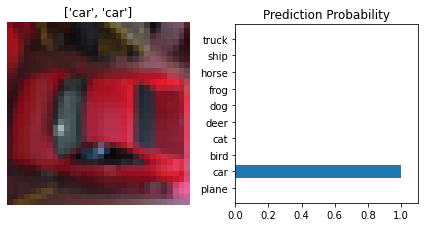

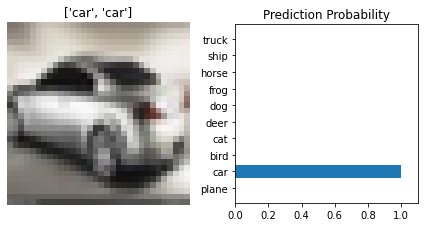

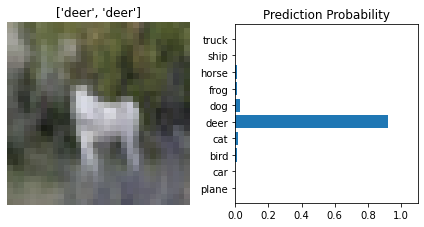

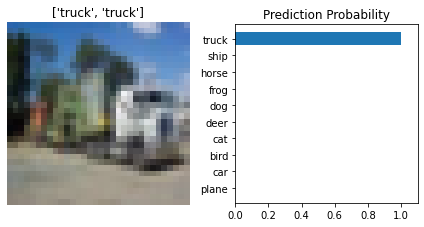

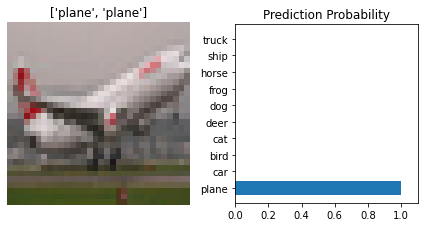

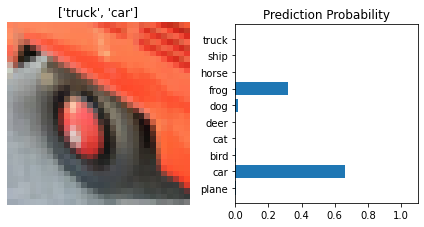

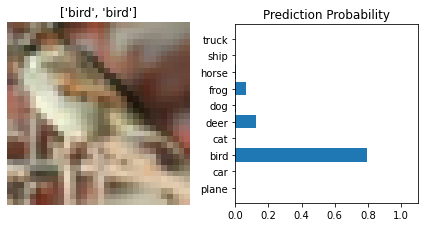

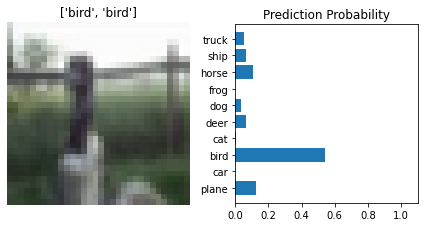

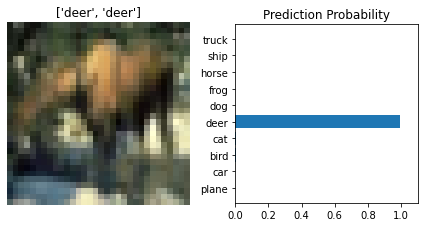

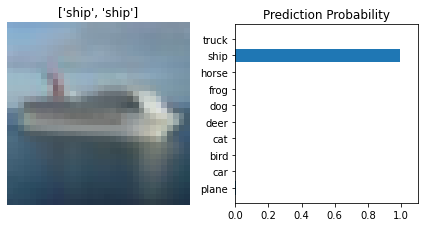

In [16]:
model_cnn.to('cpu') 
Number of parameters: 186010

# fetch a batch of test images
image_batch, label_batch = next(iter(test_loader))

# Turn off gradients to speed up this part
with torch.no_grad():
    log_pred_prob_batch = model_cnn(image_batch)
for i in range(10):
    img = image_batch[i]
    real_label = label_batch[i].item()
    log_pred_prob = log_pred_prob_batch[i]
    # Output of the network are log-probabilities, need to take exponential for probabilities
    pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()
    visualize_pred(img, pred_prob, real_label)

# Does the Convolutional Network use "Visual Information" ?

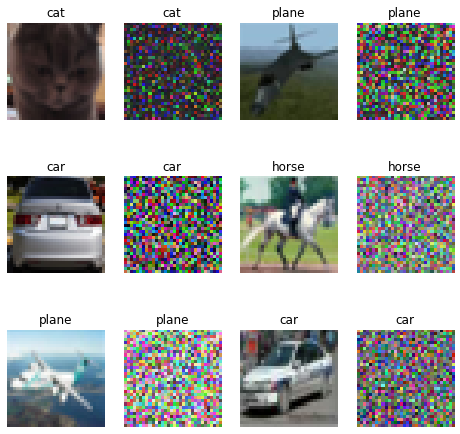

In [17]:
fixed_perm = torch.randperm(3072) # Fix a permutation of the image pixels; We apply the same permutation to all images

# show some training images
plt.figure(figsize=(8, 8))

# fetch a batch of train images; RANDOM
image_batch, label_batch = next(iter(train_loader))

for i in range(6):
    image = image_batch[i]
    image_perm = image.view(-1, 32*32*3).clone()
    image_perm = image_perm[:, fixed_perm]
    image_perm = image_perm.view(3, 32, 32)
    
    label = label_batch[i].item()
    plt.subplot(3,4 , 2*i + 1)
    #image, label = train_loader.dataset.__getitem__(i)
    #plt.imshow(image.squeeze().numpy())
    imshow(image, plt)
    plt.axis('off')
    plt.title(classNames[label])
    plt.subplot(3, 4, 2*i+2)
    #plt.imshow(image_perm.squeeze().numpy())
    imshow(image_perm, plt)
    plt.axis('off')
    plt.title(classNames[label])


In [18]:
accuracy_list = []

def scramble_train(epoch, model, perm=torch.arange(0, 3072).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 32*32*3)
        data = data[:, perm]
        data = data.view(-1, 3, 32, 32)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def scramble_test(model, perm=torch.arange(0, 3072).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 32*32*3)
        data = data[:, perm]
        data = data.view(-1, 3, 32, 32)
        
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

In [19]:
print("Training on ", device)
model_cnn_2 = CNN(input_size, output_size)
model_cnn_2.to(device)
optimizer = optim.SGD(model_cnn_2.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn_2)))

for epoch in range(0, 10):
    scramble_train(epoch, model_cnn_2, fixed_perm)
    scramble_test(model_cnn_2, fixed_perm)

Training on  cuda:0
Number of parameters: 1558026
Train Epoch: 0 [0/50000 (0%)]	Loss: 3.028028
Train Epoch: 0 [6400/50000 (13%)]	Loss: 2.300369
Train Epoch: 0 [12800/50000 (26%)]	Loss: 2.244884
Train Epoch: 0 [19200/50000 (38%)]	Loss: 1.888256
Train Epoch: 0 [25600/50000 (51%)]	Loss: 2.022595
Train Epoch: 0 [32000/50000 (64%)]	Loss: 1.813951
Train Epoch: 0 [38400/50000 (77%)]	Loss: 1.716965
Train Epoch: 0 [44800/50000 (90%)]	Loss: 1.678029

Test set: Average loss: 2.0855, Accuracy: 2921/10000 (29%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.023972
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.653855
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.713514
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.412678
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.551034
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.313132
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.473628
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.876570

Test set: Average loss: 1.6481, Accuracy: 4199/10000 (42%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.69

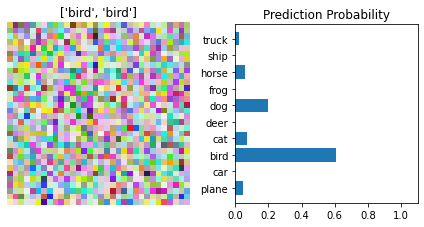

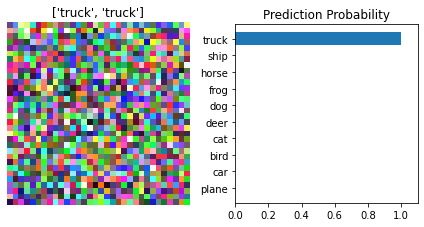

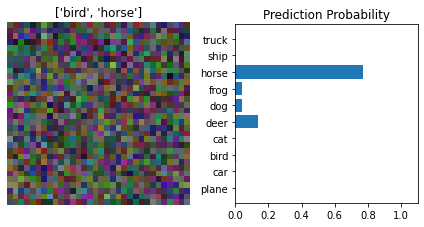

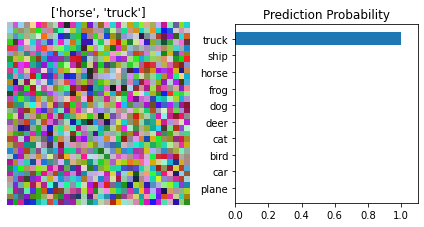

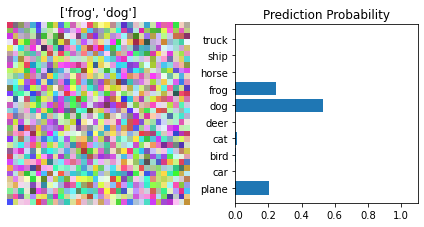

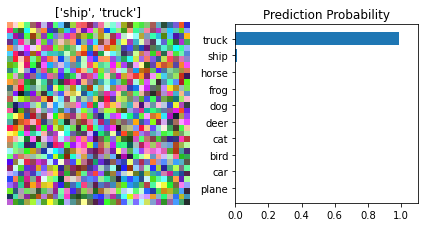

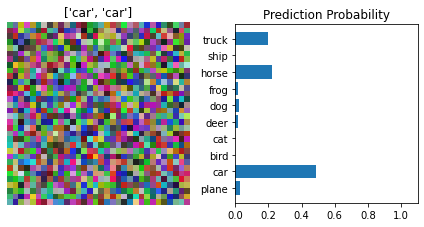

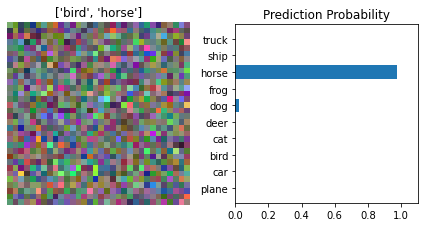

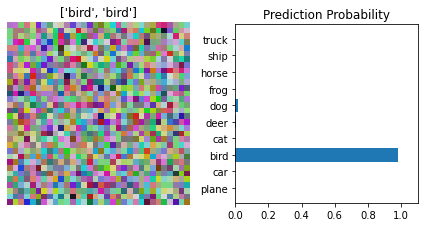

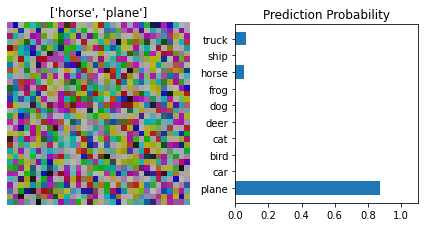

In [20]:
model_cnn_2.to('cpu') 

# fetch a batch of test images
image_batch, label_batch = next(iter(test_loader))
image_batch_scramble = image_batch.view(-1, 32*32*3)
image_batch_scramble = image_batch_scramble[:, fixed_perm]
image_batch_scramble = image_batch_scramble.view(-1, 3, 32, 32)
# Turn off gradients to speed up this part
with torch.no_grad():
    log_pred_prob_batch = model_cnn_2(image_batch_scramble)
for i in range(10):
    img = image_batch[i]
    img_perm = image_batch_scramble[i]
    real_label = label_batch[i].item()
    log_pred_prob = log_pred_prob_batch[i]
    # Output of the network are log-probabilities, need to take exponential for probabilities
    pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()
    visualize_pred(img_perm, pred_prob, real_label)